# March 6-9, 2023: Linear EI balance model: simple networks

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
from scipy import stats
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/mar23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils_v1 as dataset_utils
# import helpers.fc_utils as fc_utils
# import helpers.isc_utils as isc_utils
# import helpers.network_utils as network_utils

In [2]:
def display_fcs(args, networks, fcs) -> None:
    nrows, ncols = args.num_subjs, 1+args.num_runs
    figsize = (5*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=False, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=None
    )

    for idx_subj, network in enumerate(networks):
        ax = axs[idx_subj, 0] if nrows > 1 else axs[idx_subj]
        im = ax.imshow(network, cmap=args.cmap, vmin=-1, vmax=1)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        ax.set_title(f"{args.networks[idx_subj].name}")
        # set_matrix_ticks(args, ax)

    for (idx_subj, idx_run) in tqdm(
        list(product(range(args.num_subjs), range(args.num_runs)))
    ):
        ax = axs[idx_subj, idx_run+1] if nrows > 1 else axs[idx_run+1]
        im = ax.imshow(fcs[f"subj{idx_subj:02}"][f"run{idx_run:02}"], cmap=args.cmap, vmin=-1, vmax=1)
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.set_ylabel(f"subj{idx_subj:02}",fontsize='large')
        ax.set_title(f"sig. {args.sigmas[idx_run]:.1f}")
        # set_matrix_ticks(args, ax)

    return None

In [3]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

# args.num_subjs = 2
args.num_runs = 5
args.num_rois = 5

In [4]:
networks = []
args.networks = []

# subj0
idx_subj = 0
W = np.zeros(shape=([args.num_rois]*2))
W[0, 1] = 1
W[0, 4] = 1
W[1, 2] = -1
W[2, 3] = 1
W = (W + W.T)
networks.append(W)
args.networks.append(ARGS())
args.networks[idx_subj].name = f"nw {idx_subj}"

# subj1
idx_subj = 1
W = np.zeros(shape=([args.num_rois]*2))
W[0, 1] = -1
W[0, 4] = -1
W[1, 2] = -1
W[2, 3] = -1
W = (W + W.T)
networks.append(W)
args.networks.append(ARGS())
args.networks[idx_subj].name = f"nw {idx_subj}"

# subj2
idx_subj = 2
W = np.zeros(shape=([args.num_rois]*2))
W[0, 1] = 1
W[1, 2] = 1
W[2, 3] = -1
W[3, 4] = 1
W[4, 0] = -1
W = (W + W.T)
networks.append(W)
args.networks.append(ARGS())
args.networks[idx_subj].name = f"nw {idx_subj}"

# subj3
idx_subj = 3
W = np.zeros(shape=([args.num_rois]*2))
W[0, 1] = 1
W[1, 2] = 1
W[2, 3] = 1
W[3, 4] = 1
W[4, 0] = 1
W = (W + W.T)
networks.append(W)
args.networks.append(ARGS())
args.networks[idx_subj].name = f"nw {idx_subj}"

# subj4
idx_subj = 4
W = np.zeros(shape=([args.num_rois]*2))
W[0, 1] = 1
W[0, 4] = 1
W[1, 2] = -1
W[1, 3] = -1
W[1, 4] = 1
W[2, 3] = 1
W = (W + W.T)
networks.append(W)
args.networks.append(ARGS())
args.networks[idx_subj].name = f"nw {idx_subj}"

args.num_subjs = len(networks)

In [5]:
def to_python_vars(out_dict):
    for k, v in out_dict.items():
        out_dict[k] = np.array(v.tomemoryview().tolist())

    out_dict['t'] = out_dict['t'].squeeze()
    out_dict['x'] = out_dict['x'].T

    return out_dict
    
def simulate(eng, model_path, model, in_dict):
    eng.cd(model_path)
    out_dict = model(in_dict, nargout=1)
    out_dict = to_python_vars(out_dict)

    return out_dict

In [6]:
def plot_roi_time_series(args, time, data, roi_labels=None):
    # plot the time series of all rois.
    # %matplotlib inline
    if args.subplot_layout == 'row-col':
        nrows, ncols = int(np.ceil(args.num_rois / 5)), 5
        figsize = (5*ncols, 4*nrows)
    elif args.subplot_layout == 'row':
        nrows, ncols = args.num_rois, 1
        figsize = (10*ncols, 4*nrows)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols,
        figsize=figsize,
        sharex=False, 
        sharey=True, 
        dpi=120,
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.65
    )

    for idx_roi, roi in enumerate(np.arange(data.shape[-1])):
        if args.subplot_layout == 'row-col':
            ax = axs[idx_roi // ncols, idx_roi % ncols] if nrows > 1 else axs[idx_roi % ncols]
        elif args.subplot_layout == 'row':
            ax = axs[idx_roi]
        
        if roi_labels is not None:
            ax.set_title(f"{roi_labels[roi]}")
        else:
            ax.set_title(f"roi {idx_roi:02}")

        ax.plot(
            time,
            data[:, idx_roi],
            color='cornflowerblue',
            linewidth=3,
        )

        ax.plot(
            time,
            np.zeros_like(data[:, idx_roi]),
            color='black',
            linewidth=1.5,
            linestyle='-.',
            alpha=0.5
        )

        ax.set_xlabel(f"time (ms)")
        ax.set_ylabel(f"activity")

        ax.grid(True)

    # fig.show()

    return None

In [7]:
args.tspan = [0, 100]
args.delta_t = 0.1

In [8]:
args.sigmas = np.linspace(start=0.0, stop=1.0, num=10, endpoint=False)
args.sigmas

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [9]:
stim_rois = [1]
stimulus = np.zeros((args.num_rois,1))
stimulus[stim_rois] = 1.0
# stim_rois = [6]
# stimulus[stim_rois] = -1.0

args.A = 0.75 * np.ones(shape=(args.num_rois,1))
# args.A[1,:] = 1.0 

in_dict = {}
# in_dict['W'] = networks[0]
in_dict['A'] = matlab.double(args.A)
in_dict['B'] = 1.0
in_dict['C'] = 1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 10.0
in_dict['T'] = 25.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.0

100%|██████████| 25/25 [00:00<00:00, 49.64it/s]


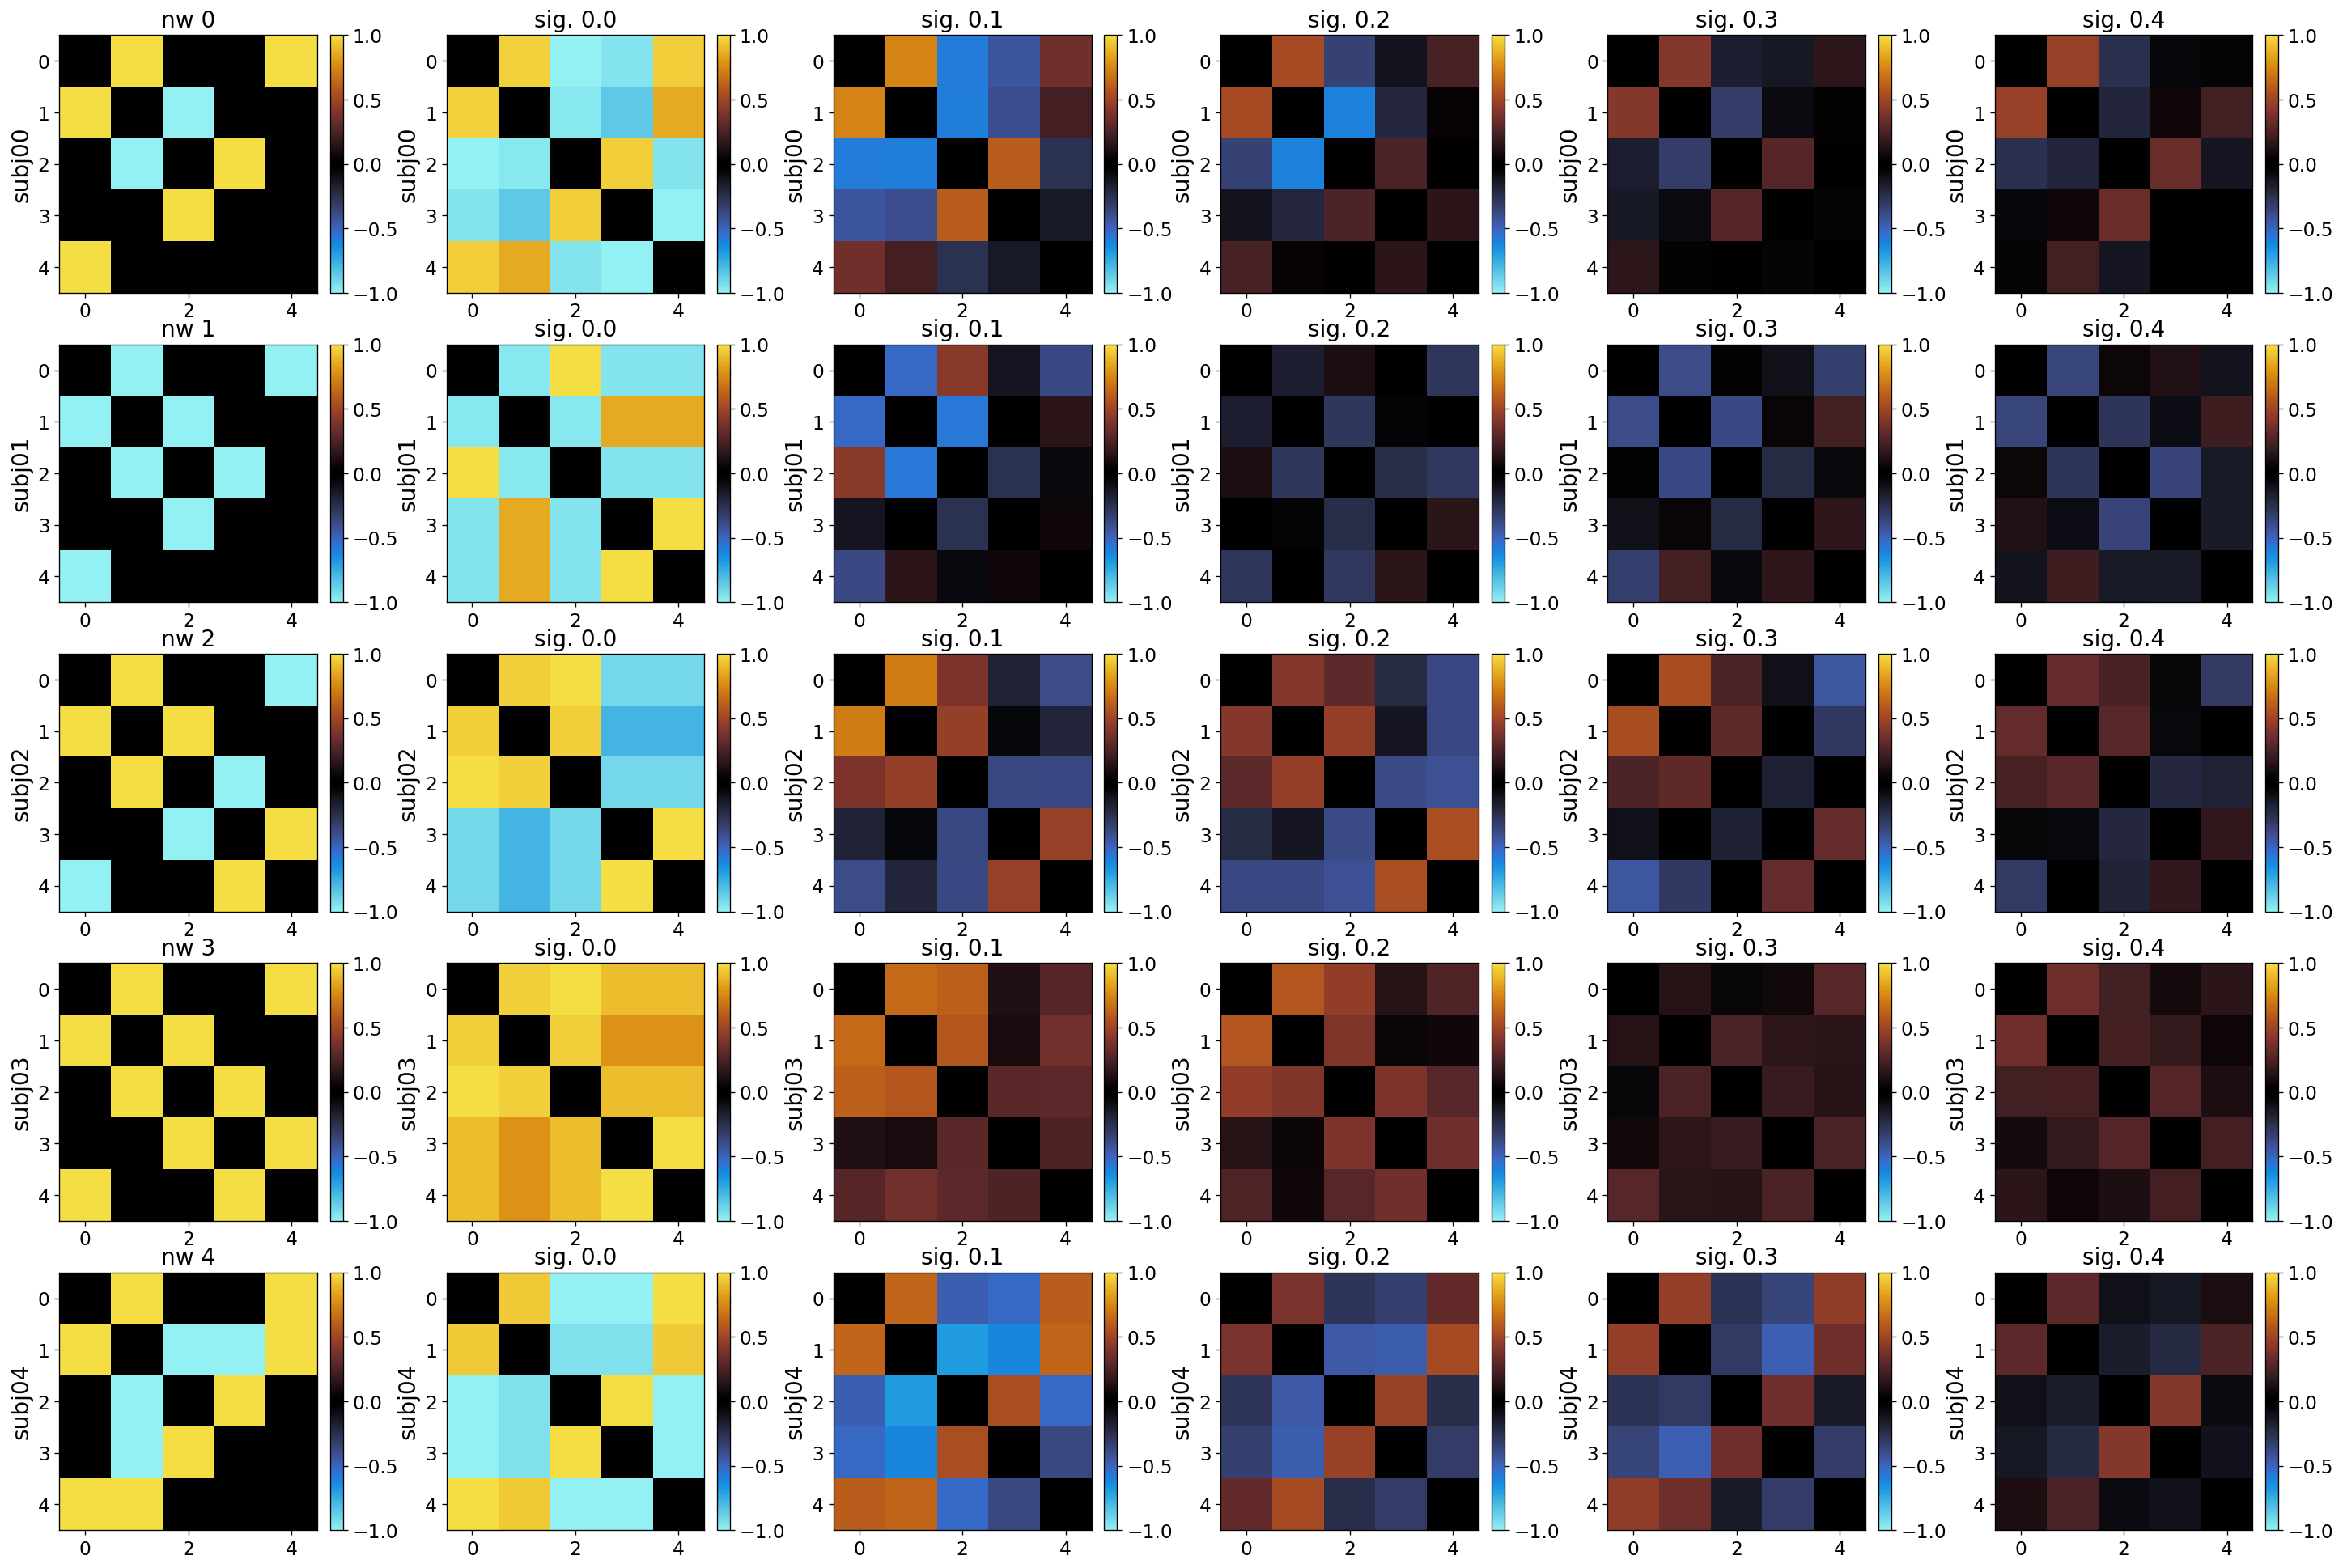

In [10]:
in_dicts = {
    f"subj{idx_subj:02}": {
        f"run{idx_run:02}": {}
        for idx_run in range(args.num_runs)
    } 
    for idx_subj in range(args.num_subjs)
}

out_dicts = copy.deepcopy(in_dicts)

# time series simulation
eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_linear_EI_balance_sde_model
for (idx_subj, idx_run) in tqdm(
    list(product(range(args.num_subjs), range(args.num_runs)))
):
    in_dict['W'] = networks[idx_subj]
    in_dict['sigma'] = args.sigmas[idx_run]
    in_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = copy.deepcopy(in_dict)
    
    out_dict = simulate(eng, model_path, model, in_dict)

    out_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = copy.deepcopy(out_dict)
eng.quit()

# functional connectivity
fcs = {
    f"subj{idx_subj:02}": {
        f"run{idx_run:02}": None
        for idx_run in range(args.num_runs)
    } 
    for idx_subj in range(args.num_subjs)
}
for (idx_subj, idx_run) in tqdm(
    list(product(range(args.num_subjs), range(args.num_runs)))
):
    out_dict = out_dicts[f"subj{idx_subj:02}"][f"run{idx_run:02}"]
    fc = stats.spearmanr(out_dict['x']).statistic
    np.fill_diagonal(fc, 0.0)
    # fc = np.log(fc)
    fcs[f"subj{idx_subj:02}"][f"run{idx_run:02}"] = fc

args.cmap = cmr.iceburn #mpl.colormaps['Oranges']
display_fcs(args, networks, fcs)

Text(0.5, 1.0, 'fc')

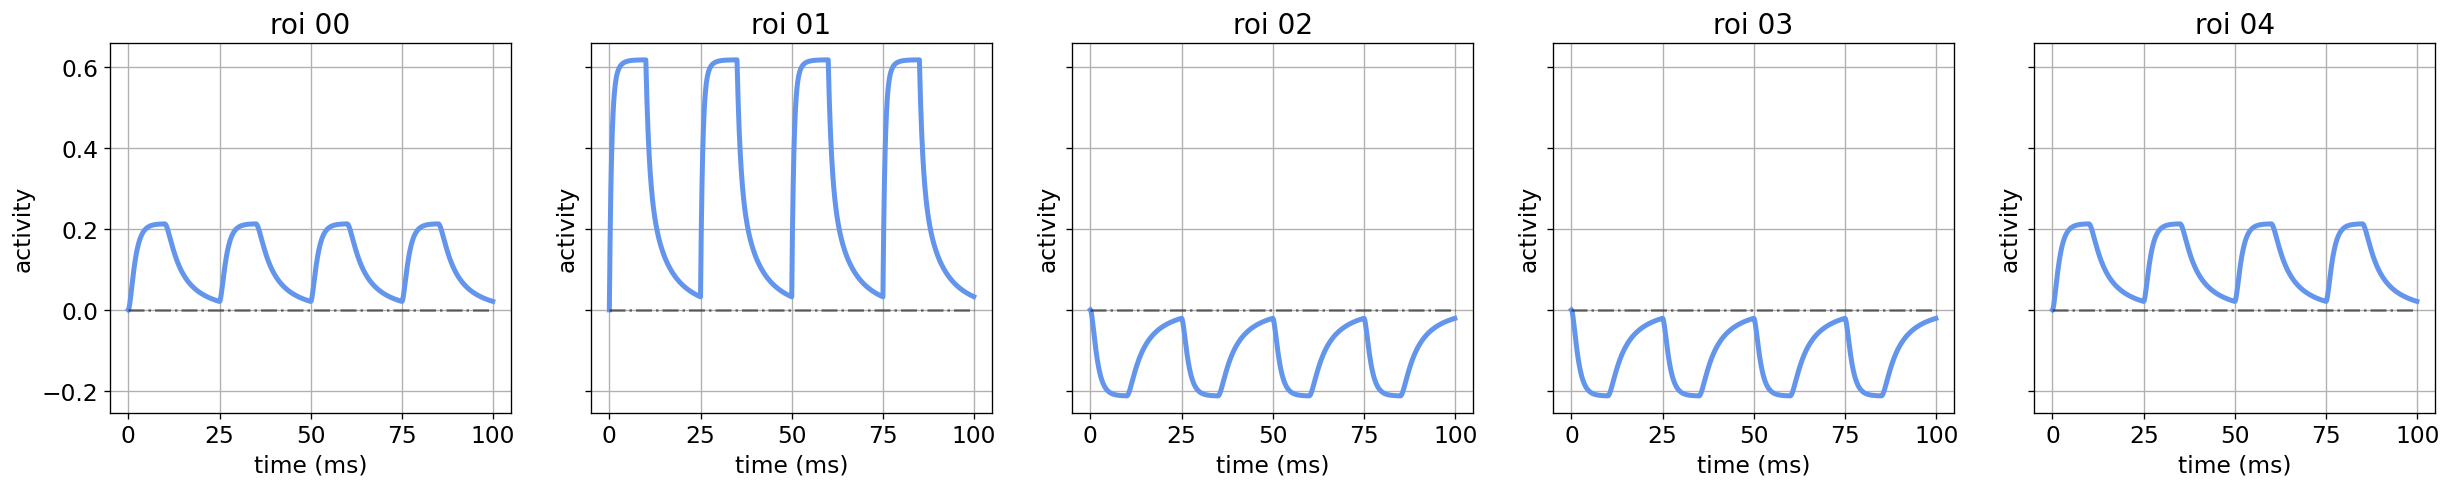

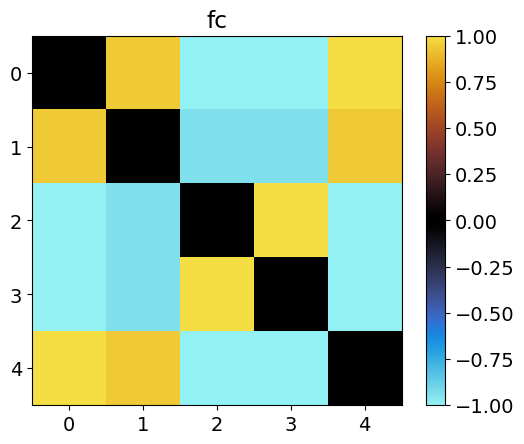

In [12]:
out_dict = out_dicts[f"subj{4:02}"][f"run{0:02}"]
args.subplot_layout = 'row-col'
plot_roi_time_series(
    args, 
    out_dict['t'],
    out_dict['x'],
)

plt.figure()
fc = stats.spearmanr(out_dict['x']).statistic
np.fill_diagonal(fc,1e-3,)
# fc = np.log(fc)
args.cmap = cmr.iceburn # mpl.colormaps['Oranges']
plt.imshow(
    fc, 
    cmap=args.cmap)
plt.colorbar()
plt.title('fc')